# DUOMENŲ NUSKAITYMAS (SCRAPING) + ANALIZĖ

### Nuskaitinėsime Coinbase keityklos apžvalgas

In [ ]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options
import os
import requests

options = Options()
options.add_argument('--incognito')

driver = webdriver.Chrome(options=options)

base_url = 'https://www.trustpilot.com/review/coinbase.com?page='
os.makedirs('trustpilot-coinbase-reviews', exist_ok=True)

def download_image(url, save_path):
    try:
        response = requests.get(url, stream=True)
        if response.status_code == 200:
            with open(save_path, 'wb') as file:
                for chunk in response.iter_content(1024):
                    file.write(chunk)
    except Exception as e:
        print(f"Failed {url}: {e}")

reviews = []
for page in range(2, 3): # testing
    url = f"{base_url}{page}"
    driver.get(url)

    driver.implicitly_wait(0.9)
    reviews = driver.find_elements(By.CLASS_NAME, 'styles_reviewCardInner__EwDq2')
    
    for i, review in enumerate(reviews):
        rating = review.find_element(By.CLASS_NAME, 'star-rating_starRating__4rrcf').find_element(By.TAG_NAME, 'img').get_attribute('alt')
        rating = rating[6]
        title = review.find_element(By.CLASS_NAME, 'typography_heading-s__f7029').text.strip()
        date = review.find_element(By.CLASS_NAME, 'typography_body-m__xgxZ_.typography_appearance-default__AAY17').text.strip()
        date = date.replace('Date of experience:', '').strip()

            
        print("Rating:", rating)
        print("Title:", title)
        print("Date:", date)
        print("-" * 50)
driver.quit()


Rating: 1
Title: Violation of laws and regulations
Date: June 03, 2024
--------------------------------------------------
Rating: 1
Title: Australians DO NOT USE dont do it
Date: June 03, 2024
--------------------------------------------------
Rating: 2
Title: Important information missing for me
Date: May 23, 2024
--------------------------------------------------
Rating: 1
Title: Account verification
Date: May 23, 2024
--------------------------------------------------
Rating: 1
Title: Worst customer service i have ever…
Date: May 23, 2024
--------------------------------------------------
Rating: 5
Title: Faultless experience using Coinbase for 18 months…
Date: May 21, 2024
--------------------------------------------------
Rating: 2
Title: Wouldn't recommend this platform.
Date: April 29, 2024
--------------------------------------------------
Rating: 1
Title: Arbitrary 60 Day Freeze - BEWARE **UPDATE** - EVEN WORSE!
Date: May 27, 2024
----------------------------------------------

In [ ]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options
import csv
from dateutil import parser


options = Options()
options.add_argument('--incognito')
driver = webdriver.Chrome(options=options)

base_url = 'https://www.trustpilot.com/review/coinbase.com?page='

reviews_data = []
try:
    for page in range(1, 325): # full scraping
        url = f"{base_url}{page}"
        driver.get(url)

        driver.implicitly_wait(0.6)
        try:
            reviews = driver.find_elements(By.CLASS_NAME, 'styles_reviewCardInner__EwDq2')
        except Exception as e:
            print(f"!! PAGE EXCEPTION: {e}")
            continue        
        for review in reviews:
            try:
                rating = review.find_element(By.CLASS_NAME, 'star-rating_starRating__4rrcf').find_element(By.TAG_NAME, 'img').get_attribute('alt')
                rating = rating[6]
                title = review.find_element(By.CLASS_NAME, 'typography_heading-s__f7029').text.strip()
                date = review.find_element(By.CLASS_NAME, 'typography_body-m__xgxZ_.typography_appearance-default__AAY17').text.strip()
                date = date.replace('Date of experience:', '').strip()
                date = parser.parse(date).strftime('%Y-%m-%d')

                reviews_data.append([date, title, rating])
            except Exception as e:
                print(f"!! ATTRIBUTE EXCEPTION: {e}")
                continue
finally:
    driver.quit() # if uncaught except still uzdarom

csv_file = 'trustpilot_coinbase_reviews-strip.csv'
with open(csv_file, mode='w', newline='', encoding='UTF-8') as file:
    writer = csv.writer(file, delimiter='|')
    writer.writerow(['Date', 'Title', 'Rating'])
    writer.writerows(reviews_data)

print(f"SAVED!\n{csv_file}")

In [1]:
import pandas as pd
df = pd.read_csv('trustpilot_coinbase_reviews-strip.csv', sep='|')
df.head()

Date                                  Title  Rating
0  2024-05-24  200k still locked. WHERE IS MY MONEY?     1.0
1  2024-06-04                          Dishonourable     1.0
2  2024-05-28     Coinbase tried to remove my review     1.0
3  2024-06-04  Entrée en matière grâce aux p2e games     4.0
4  2024-05-31   Okay until you want your money back!     1.0

In [2]:
df.tail()

Date                                              Title  Rating
6475  2017-05-22              Very bad.I can't register any of my …     1.0
6476  2017-05-19  Functional platform but seriously lacking in c...     3.0
6477  2017-05-18                                   No reservations.     5.0
6478  2017-05-18              I HOPE YOU SEE THIS BEFORE You send …     1.0
6479  2017-05-16                Coinbase - the rock star crypto app     4.0

In [ ]:
print(f'Total: {len(df)}\n')
print(df['Rating'].value_counts(), '\n')
print(f'Average: {df["Rating"].mean()}')


Total: 6480

Rating
1.0    5428
5.0     364
2.0     280
3.0     233
4.0     148
Name: count, dtype: int64 

Average: 1.4100418410041842


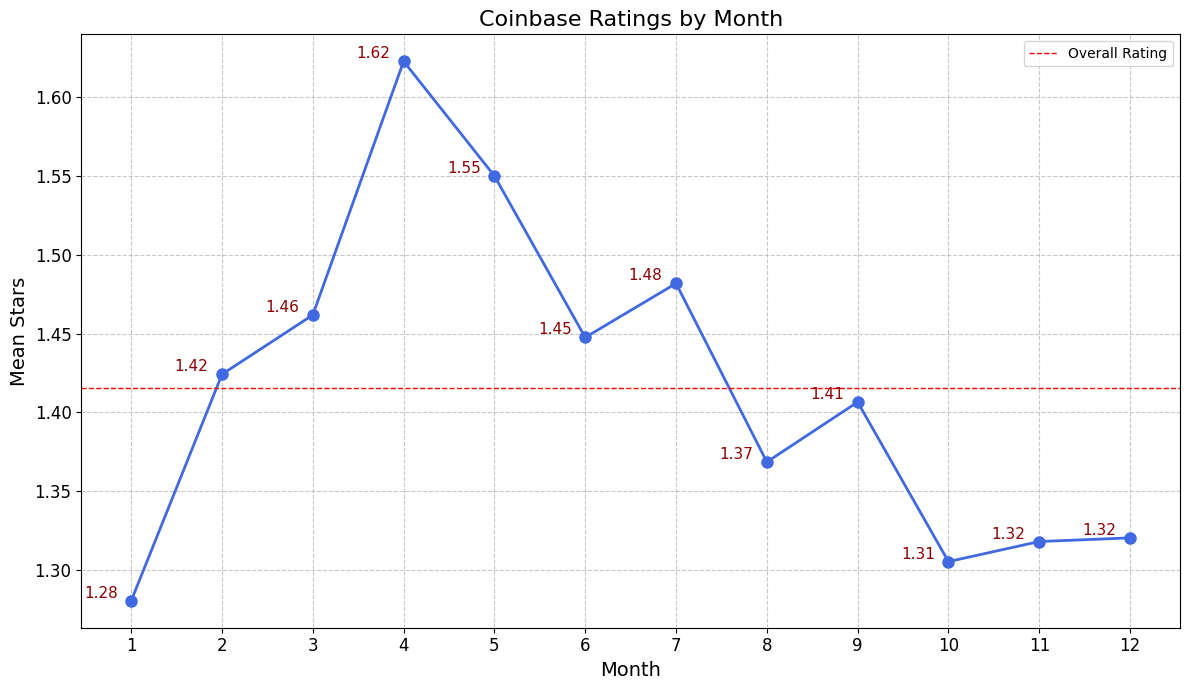

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

def is_date(date):
    try:
        pd.to_datetime(date, format='%Y-%m-%d')
        return True
    except ValueError:
        return False

df = df[df['Date'].apply(is_date)]

df['Date'] = pd.to_datetime(df['Date'])
df['Month'] = df['Date'].dt.month

month_avg = df.groupby('Month')['Rating'].mean()

plt.figure(figsize=(12, 7))
plt.plot(month_avg.index, month_avg.values, marker='o', linestyle='-', color='royalblue', linewidth=2, markersize=8)
plt.xlabel('Month', fontsize=14)
plt.ylabel('Mean Stars', fontsize=14)
plt.title('Coinbase Ratings by Month', fontsize=16)
plt.xticks(month_avg.index, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.axhline(y=month_avg.mean(), color='red', linestyle='--', linewidth=1, label='Overall Rating')
plt.legend()

# data points
for i, value in enumerate(month_avg.values):
    plt.text(month_avg.index[i] - 0.15, value, f'{value:.2f}', fontsize=11, ha='right', va='bottom', color='darkred') # x-offset; horiz alig; vert alig

plt.tight_layout()
plt.show()



# DUOMENŲ RINKINIAI (BTC kainos), analizė

- https://www.kaggle.com/datasets/mjdskaggle/5-years-of-crypto-data-as-of-632024 BTC-USD.csv
- https://coinmarketcap.com/currencies/bitcoin/ BTC_All_graph_coinmarketcap.csv
- https://www.kaggle.com/datasets/prkhrawsthi/bitcoin-usd-daily-price-with-volume-2015-2023 BTC-USD-15-23.csv



In [ ]:
import pandas as pd
from dateutil import parser

btc_new = pd.read_csv('BTC-USD.csv') # 2019-06-03 to 2024-06 ---> daily
btc_old = pd.read_csv('BTC_All_graph_coinmarketcap.csv', delimiter=';') # 2013-2019 ---> monthly

columns = ['Date', 'Close', 'Volume']

btc_new = btc_new[['Date', 'Adj Close', 'Volume']]
btc_new.columns = columns
btc_old = btc_old[['timestamp', 'close', 'volume']]
btc_old.columns = columns

btc_new['Date'] = btc_new['Date'].apply(lambda x: parser.parse(x).strftime('%Y-%m-%d'))
btc_old['Date'] = btc_old['Date'].apply(lambda x: parser.parse(x).strftime('%Y-%m-%d'))

min_date_recent = btc_new['Date'].min() # oldest

btc_old = btc_old.loc[btc_old['Date'] < min_date_recent] # remove new data from btc_old

btc_all = pd.concat([btc_old, btc_new])
btc_all.to_csv('combined_btc_data.csv', index=False)
btc_all['Date'] = pd.to_datetime(btc_all['Date']) 


In [ ]:
import pandas as pd
from dateutil import parser

btc_new = pd.read_csv('BTC-USD.csv')  # 2019-06-03 to 2024-06 ---> daily
btc_mid = pd.read_csv('BTC-USD-15-23.csv')  # 2015-2023 ---> daily
btc_old = pd.read_csv('BTC_All_graph_coinmarketcap.csv', delimiter=';')  # 2013-2019 ---> monthly

columns = ['Date', 'Close', 'Volume']

btc_new = btc_new[['Date', 'Adj Close', 'Volume']]
btc_new.columns = columns
btc_old = btc_old[['timestamp', 'close', 'volume']]
btc_old.columns = columns
btc_mid = btc_mid[['Date', 'Adj Close', 'Volume']]
btc_mid.columns = columns

btc_new['Date'] = btc_new['Date'].apply(lambda x: parser.parse(x).strftime('%Y-%m-%d'))
btc_old['Date'] = btc_old['Date'].apply(lambda x: parser.parse(x).strftime('%Y-%m-%d'))
btc_mid['Date'] = btc_mid['Date'].apply(lambda x: parser.parse(x).strftime('%Y-%m-%d'))

# remove new data from older files
min_date_mid = btc_mid['Date'].min()
min_date_new = btc_new['Date'].min()

btc_old = btc_old.loc[btc_old['Date'] < min_date_mid]
btc_mid = btc_mid.loc[btc_mid['Date'] < min_date_new]

btc_all = pd.concat([btc_old, btc_mid, btc_new])
btc_all.to_csv('combined_btc_data.csv', index=False)
btc_all['Date'] = pd.to_datetime(btc_all['Date'])

### Pridedame papildomas Features (Open/High/Low)

In [ ]:
import pandas as pd
from dateutil import parser

btc2_new = pd.read_csv('BTC-USD.csv')  # 2019-06-03 to 2024-06 ---> daily
btc2_mid = pd.read_csv('BTC-USD-15-23.csv')  # 2015-2023 ---> daily
btc2_old = pd.read_csv('BTC_All_graph_coinmarketcap.csv', delimiter=';')  # 2013-2019 ---> monthly

columns = ['Date', 'Open', 'High', 'Low', 'Close', 'Volume']

btc2_new = btc2_new[['Date', 'Open', 'High', 'Low', 'Adj Close', 'Volume']]
btc2_new.columns = columns
btc2_old = btc2_old[['timestamp', 'open', 'high', 'low', 'close', 'volume']]
btc2_old.columns = columns
btc2_mid = btc2_mid[['Date', 'Open', 'High', 'Low', 'Adj Close', 'Volume']]
btc2_mid.columns = columns

btc2_new['Date'] = btc2_new['Date'].apply(lambda x: parser.parse(x).strftime('%Y-%m-%d'))
btc2_old['Date'] = btc2_old['Date'].apply(lambda x: parser.parse(x).strftime('%Y-%m-%d'))
btc2_mid['Date'] = btc2_mid['Date'].apply(lambda x: parser.parse(x).strftime('%Y-%m-%d'))

# remove new data from older files
min_date_mid = btc2_mid['Date'].min()
min_date_new = btc2_new['Date'].min()

btc2_old = btc2_old.loc[btc2_old['Date'] < min_date_mid]
btc2_mid = btc2_mid.loc[btc2_mid['Date'] < min_date_new]

btc2_all = pd.concat([btc2_old, btc2_mid, btc2_new])
btc2_all.to_csv('combined_btc2_data.csv', index=False)
btc2_all['Date'] = pd.to_datetime(btc_all['Date'])

In [ ]:
btc2_old

Date          Open          High           Low  \
0    2013-04-01T00:00:00.000Z    135.300003    147.488007    132.100006   
1    2013-05-01T00:00:00.000Z    139.000000    139.889999     79.099998   
2    2013-06-01T00:00:00.000Z    128.815002    129.779999     88.500000   
3    2013-07-01T00:00:00.000Z     97.510002    111.344002     65.526001   
4    2013-08-01T00:00:00.000Z    106.212997    140.889999    101.210999   
..                        ...           ...           ...           ...   
130  2024-02-01T00:00:00.000Z  42569.761398  63913.131814  41879.189991   
131  2024-03-01T00:00:00.000Z  61168.062429  73750.073850  59323.908942   
132  2024-04-01T00:00:00.000Z  71333.484717  72715.359609  59120.068047   
133  2024-05-01T00:00:00.000Z  60609.497946  71946.462688  56555.294055   
134      2024-06-01T00:00:00Z  67475.431181  71321.775649  67318.447828   

            Close        Volume  
0      139.000000  0.000000e+00  
1      129.000000  0.000000e+00  
2       96.613998  0.000000e+00  
3      106.089996  0.000000e+00  
4      135.350006  0.000000e+00  
..            ...           ...  
130  61198.382897  8.307219e+11  
131  71333.647926  1.446418e+12  
132  60636.856780  1.016068e+12  
133  67491.417011  8.742915e+11  
134  70959.476755  0.000000e+00  

[135 rows x 6 columns]

In [ ]:
btc_all.head(20)

Date        Close      Volume
0  2013-04-01   139.000000         0.0
1  2013-05-01   129.000000         0.0
2  2013-06-01    96.613998         0.0
3  2013-07-01   106.089996         0.0
4  2013-08-01   135.350006         0.0
5  2013-09-01   133.000000         0.0
6  2013-10-01   204.000000         0.0
7  2013-11-01  1129.430054         0.0
8  2013-12-01   754.010010  20897300.0
9  2014-01-01   829.919983  17107900.0
10 2014-02-01   549.260010  28076100.0
11 2014-03-01   457.001007  28254000.0
12 2014-04-01   447.644989  15244900.0
13 2014-05-01   623.677002  15107100.0
14 2014-06-01   639.796997  46422400.0
15 2014-07-01   586.234985  22467900.0
16 2014-08-01   477.763000  44632300.0
17 2014-09-01   386.944000  34707300.0
18 2014-10-01   338.321014  12545400.0
19 2014-11-01   378.046997   9194440.0

In [ ]:
btc_all.tail(20)

Date         Close        Volume
1808 2024-05-15  66267.492188  3.981517e+10
1809 2024-05-16  65231.582031  3.157308e+10
1810 2024-05-17  67051.875000  2.803128e+10
1811 2024-05-18  66940.804688  1.671228e+10
1812 2024-05-19  66278.367188  1.924909e+10
1813 2024-05-20  71448.195313  4.385066e+10
1814 2024-05-21  70136.531250  4.693201e+10
1815 2024-05-22  69122.335938  3.280256e+10
1816 2024-05-23  67929.562500  4.189568e+10
1817 2024-05-24  68526.101563  2.919731e+10
1818 2024-05-25  69265.945313  1.547307e+10
1819 2024-05-26  68518.093750  1.562843e+10
1820 2024-05-27  69394.554688  2.587099e+10
1821 2024-05-28  68296.218750  3.272227e+10
1822 2024-05-29  67578.093750  2.670707e+10
1823 2024-05-30  68364.992188  2.950971e+10
1824 2024-05-31  67491.414063  2.738728e+10
1825 2024-06-01  67706.937500  1.164150e+10
1826 2024-06-02  67751.601563  1.711059e+10
1827 2024-06-03  69212.054688  3.036929e+10

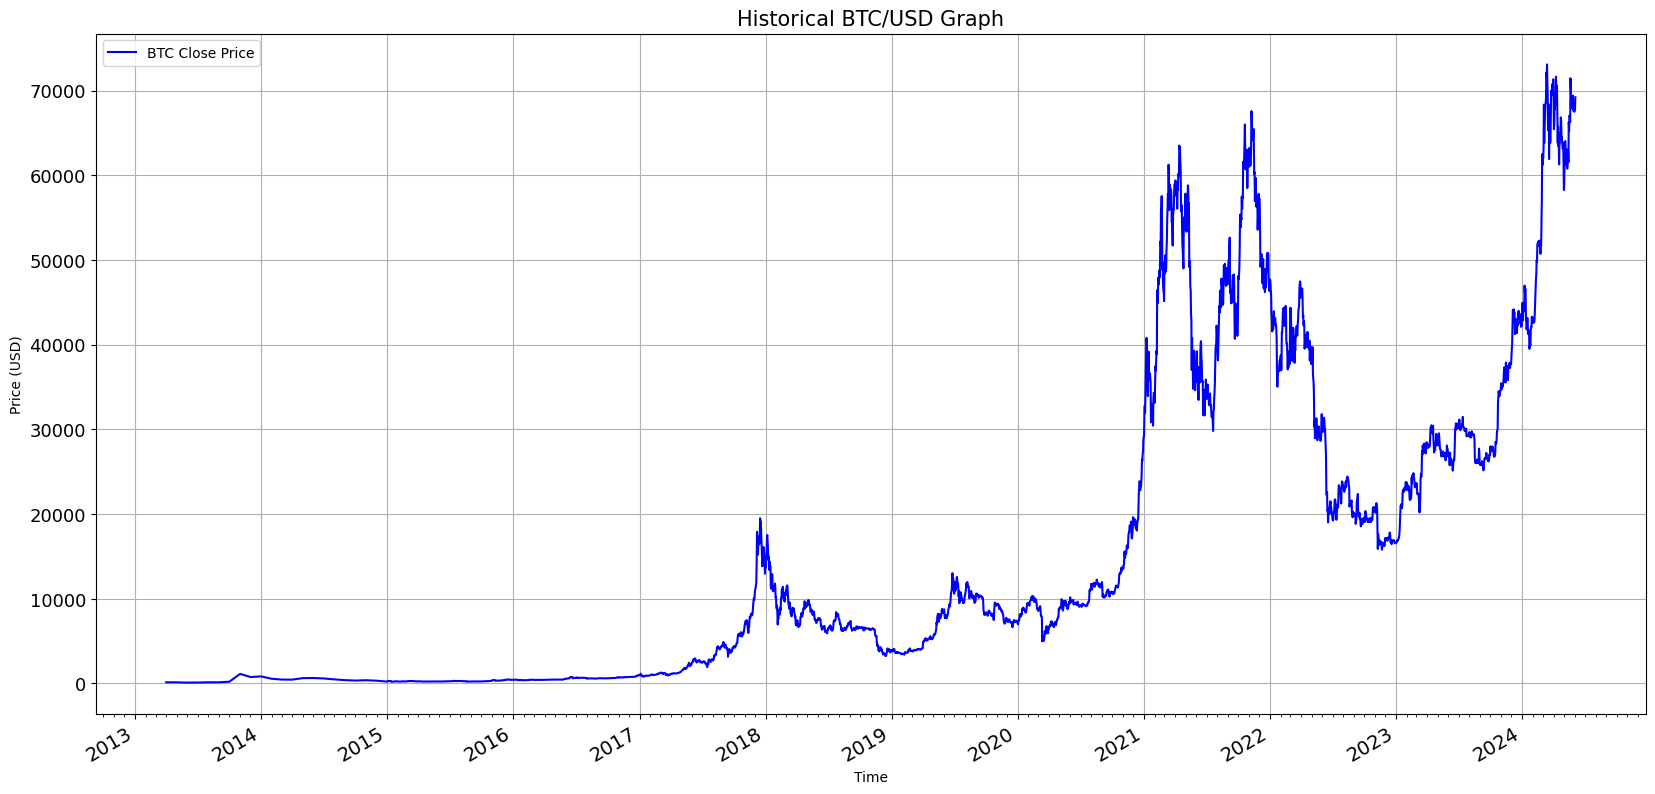

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

btc_all = pd.read_csv('combined_btc_data.csv')
btc_all['Date'] = pd.to_datetime(btc_all['Date'])

plt.figure(figsize=(20, 10))
plt.plot(btc_all['Date'], btc_all['Close'].astype(float), label='BTC Close Price', color='blue')
plt.title('Historical BTC/USD Graph', size=15)
plt.xlabel('Time')
plt.ylabel('Price (USD)')
plt.xticks(size=14)
plt.yticks(size=13)
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_minor_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# Rotate the date labels for better visibility
plt.gcf().autofmt_xdate()
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
print(f"Avg: {btc_all['Close'].mean()}")
print(f"Min: {btc_all['Close'].min()}")
print(f"Max: {btc_all['Close'].max()}")

Avg: 28072.281185546482
Min: 96.6139984131
Max: 73083.5


In [ ]:
btc_all['Year'] = btc_all['Date'].dt.year  
btc_all.groupby('Year')['Close'].mean()

Year
2013      314.054896
2014      502.900248
2015      272.070514
2016      568.492407
2017     4006.033629
2018     7572.298947
2019     7395.246282
2020    11116.378092
2021    47436.932021
2022    28197.754099
2023    28859.448250
2024    58581.041961
Name: Close, dtype: float64

In [ ]:
btc_all['Month'] = btc_all['Date'].dt.month  
means = btc_all.groupby('Month')['Close'].mean()
print(means.mean())
btc_all.groupby('Month')['Close'].mean()

16802.355089680517


Month
1     16581.081613
2     18429.223664
3     21082.083670
4     21428.599174
5     19728.467045
6     13533.243163
7     12899.745897
8     14303.570023
9     13682.792516
10    15487.687104
11    17005.220142
12    17466.547064
Name: Close, dtype: float64

In [ ]:
btc_all['Day'] = btc_all['Date'].dt.day  
means = btc_all.groupby('Day')['Close'].mean()
print(means.mean())
btc_all.groupby('Day')['Close'].mean()

16927.799850416148


Day
1     14571.056135
2     17337.106689
3     17249.737375
4     16826.712662
5     16866.903985
6     16990.074149
7     17000.850060
8     17135.397201
9     17156.519038
10    17034.904653
11    17038.997118
12    16913.913252
13    17040.686737
14    17087.293796
15    17142.969808
16    17011.591174
17    16997.833359
18    16939.968996
19    16946.376119
20    17124.801709
21    16822.517876
22    16731.949426
23    16770.772555
24    16761.818510
25    16814.819584
26    16885.320838
27    16984.972608
28    17121.013664
29    17125.884724
30    16967.141260
31    17361.890303
Name: Close, dtype: float64

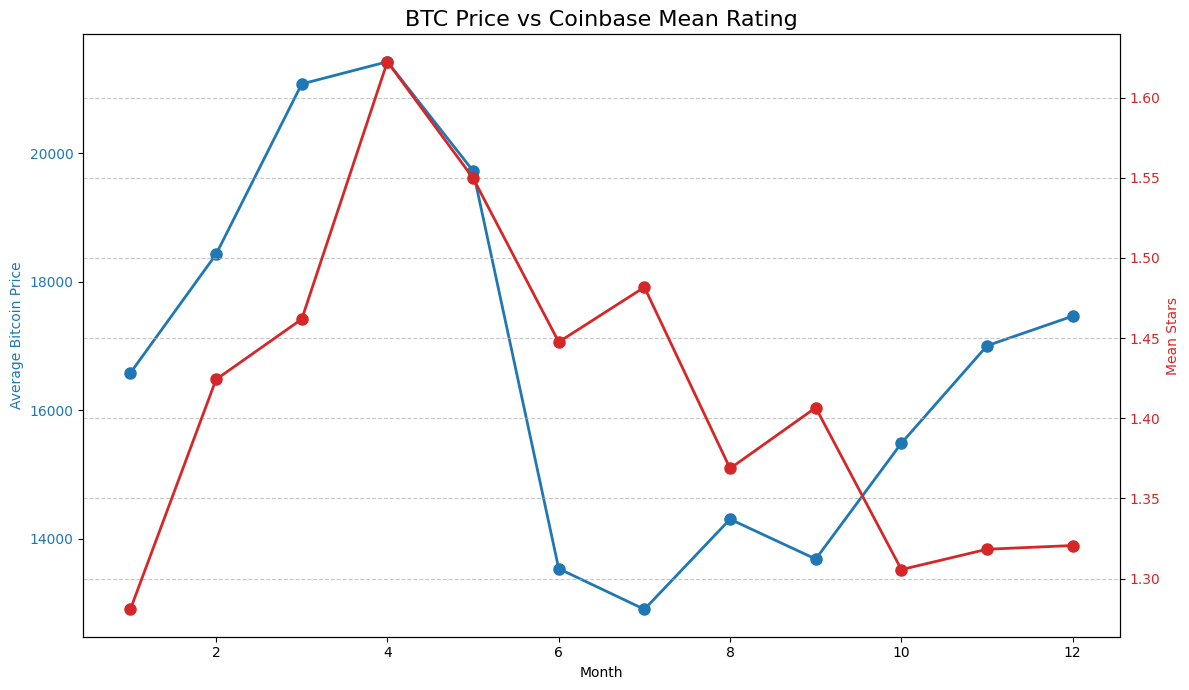

In [8]:
import pandas as pd
import matplotlib.pyplot as plt


def is_date(date):
    try:
        pd.to_datetime(date, format='%Y-%m-%d')
        return True
    except ValueError:
        return False

df = df[df['Date'].apply(is_date)]
df['Date'] = pd.to_datetime(df['Date'])
df['Month'] = df['Date'].dt.month

ratings_mean = df.groupby('Month')['Rating'].mean()
btc_all['Date'] = pd.to_datetime(btc_all['Date'])
btc_all['Month'] = btc_all['Date'].dt.month
btc_means = btc_all.groupby('Month')['Close'].mean()

fig, ax1 = plt.subplots(figsize=(12, 7))

color = 'tab:blue'
ax1.set_xlabel('Month')
ax1.set_ylabel('Average Bitcoin Price', color=color)
ax1.plot(btc_means.index, btc_means.values, color=color, marker='o', linestyle='-', linewidth=2, markersize=8)
ax1.tick_params(axis='y', labelcolor=color)
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Mean Stars', color=color)
ax2.plot(ratings_mean.index, ratings_mean.values, color=color, marker='o', linestyle='-', linewidth=2, markersize=8)
ax2.tick_params(axis='y', labelcolor=color)

plt.title('BTC Price vs Coinbase Mean Rating', fontsize=16)
fig.tight_layout()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

Matome kad keityklos reitingas panašu, jog iš tiesų yra **priklausomas** nuo to kokia kriptovaliūtos vertė yra tam tikru laikotarpiu koreliacijos atžvilgiu (kyla/ledžiasi).<br> Galime daryti prielaidą, kad krentant kriptovaliūtų kainoms keityklai tampa sudėtingiau vykdyti savo veiklą ar įgyvendinti užsibrėžtus tikslus ko pasekoje nepatenkintų vartotojų skaičius auga. Mažėjant kainai vidutinis įvertinimo reitingas taipogi krenta beveik iškart su minimaliu atsilikimu. Augimo kriterijai sutampa beveik identišku principu.